In [13]:
import logging
from binance.um_futures import UMFutures as Client
from binance.lib.utils import config_logging
from binance.error import ClientError
import dateparser
import pandas as pd
import numpy as np
import json
import matplotlib.pyplot as plt
import os
from scipy import signal
from datetime import datetime

In [19]:
###

akey = os.environ.get("API_KEY")
asec = os.environ.get("API_SECRET")
futures_client = Client(key = akey, secret= asec)

###

#DATA PARAMETERS

PREFIX = os.getcwd()
BLOCK = 512
DUMP = '.csv'
DATA_DIR = os.path.join(PREFIX, "datasets")

###

TIMEFRAME = "15m"
PAIR = "ETHUSDT"
# FROM_DATE = "2022-01-14 01:00:00" 
# TO_DATE = "2022-10-05 01:00:00"
FROM_DATE = "2019-11-14" 
TO_DATE = "2022-10-17"
NUM_DATA = 600 

###

#PARAMETERS

DATA_WINDOW_LENGTH = BLOCK
ROLLING_WINDOW_LENGTH = 12 #this is correlated with the chosen TIMEFRAME and as such should be a function of that; something about the frequency of local minima and maxima
CALLBACKRATE_FACTOR = 10

###

dir_name = f"{NUM_DATA}_{PAIR}_{TIMEFRAME}_{FROM_DATE.replace(' ', '-').replace(':', '')}_{TO_DATE.replace(' ', '-').replace(':', '')}"

NEW_DATA_DIR = os.path.join(PREFIX, DATA_DIR, dir_name)

if not os.path.exists(NEW_DATA_DIR):
    os.makedirs(NEW_DATA_DIR)
print(NEW_DATA_DIR)    

c:\Users\igor-\.cloned\trailing_orders-1\DEV\datasets\600_ETHUSDT_15m_2019-11-14_2022-10-17


In [20]:
class StaticDatabase:
    def __init__(self, client, pair, timeframe, from_date, to_date, contractType = 'PERPETUAL', limit=1000):
        self.client = client
        self.pair = pair
        self.timeframe = timeframe
        self.contractType = contractType
        self.limit = limit
        self.from_date = pd.Timestamp(from_date)
        self.to_date = pd.Timestamp(to_date)        
        self.from_ts = round(datetime.timestamp(pd.to_datetime(self.from_date, unit="ms")))*1000
        self.to_ts = round(datetime.timestamp(pd.to_datetime(self.to_date, unit="ms")))*1000
        self.data = self.process_klines(self.client.continuous_klines(self.pair, self.contractType, self.timeframe, startTime = self.from_ts, limit = self.limit)) 
        # self.last_ts = round(datetime.timestamp(pd.to_datetime(self.data.iloc[-1]['close_time'], unit='ms')))   
        self.last_ts = self.data.iloc[-1]['timestamp']   
        self.length = len(self.data)
        # self.data = pd.DataFrame()
    
    def get_historical_klines(self):

        # print(self.last_ts < self.to_ts)
        
        while (self.length < NUM_DATA) and (self.last_ts < self.to_ts):
            
            if self.length % 1000 == 0: print(self.last_ts < self.to_ts)
            # print(1)
            print(self.data.shape)        
            self.new_data = self.process_klines(self.client.continuous_klines(self.pair, self.contractType, self.timeframe, startTime = self.last_ts, limit=self.limit))
            self.data = pd.concat([self.data, self.new_data], axis=0).reset_index(drop=True)
            self.length = len(self.data)
            # print(self.data.iloc[-1]['timestamp'] > self.last_ts)
            self.last_ts = self.data.iloc[-1]['timestamp']
            
        # print(self.last_ts < self.to_ts)

        # self.dump_data()                    
                
    def process_klines(self, klines):
        df = pd.DataFrame(klines)
        df.columns = ['open_time', 'open', 'high', 'low', 'close', 'volume', 'close_time', 'quote_asset_volume', 'trades', 'taker_buy_volume', 'taker_buy_quote_asset_volume', 'ignore']
        df['timestamp'] = df['open_time']
        df['open_time'] = pd.to_datetime(df['open_time'], unit='ms')
        df['close_time'] = pd.to_datetime(df['close_time'], unit='ms')
        df['open'] = pd.to_numeric(df['open'])
        df['high'] = pd.to_numeric(df['high'])
        df['low'] = pd.to_numeric(df['low'])
        df['close'] = pd.to_numeric(df['close'])
        df['volume'] = pd.to_numeric(df['volume'])
        df['quote_asset_volume'] = pd.to_numeric(df['quote_asset_volume'])
        df['trades'] = pd.to_numeric(df['trades'])
        df['taker_buy_volume'] = pd.to_numeric(df['taker_buy_volume'])
        df['taker_buy_quote_asset_volume'] = pd.to_numeric(df['taker_buy_quote_asset_volume'])
        df['ignore'] = pd.to_numeric(df['ignore'])
        df.drop(['ignore'], axis=1, inplace=True)
        # df.drop(['close_time'], axis=1, inplace=True)
        return df

    def make_features_and_labels(self):
        df = self.data
        
        df["closes_ema"] = df.close.ewm(halflife=pd.Timedelta(TIMEFRAME)/4, ignore_na=True, min_periods=ROLLING_WINDOW_LENGTH, times=df.open_time).mean()
        df["closes_std"] = df.close.ewm(halflife=pd.Timedelta(TIMEFRAME)/4, ignore_na=True, min_periods=ROLLING_WINDOW_LENGTH, times=df.open_time).std()
        df["closes_z"] = (df.close - df.closes_ema) / df.closes_std
        df["closes_z"] = df.closes_z.ewm(halflife=pd.Timedelta(TIMEFRAME)/4, ignore_na=True, min_periods=ROLLING_WINDOW_LENGTH, times=df.open_time).mean()
        
        features = self.data[
            ['open_time', 'open', 'high', 'low', 'close', 'volume',
             'quote_asset_volume', 'trades', 'taker_buy_volume',
              'taker_buy_quote_asset_volume', 'closes_ema', 'closes_std',
               'closes_z']
              ]
        self.features = features


        ###

        #LABEL
        
        mean_std = df.closes_std.mean()

        # peak_indexes, _ = signal.find_peaks(df.close.values, threshold=mean_std/2)
        # peak_indexes, _ = signal.find_peaks(df.close.values, prominence=1.5*mean_std)
        peak_indexes, _ = signal.find_peaks(df.close.values, prominence=2*mean_std)
        peak_regions = []
        
        for peak_index in peak_indexes:

            peak_regions.append(peak_index)

            for j in range(min(max(peak_index, len(df.close.values) - max(peak_indexes))-1, 5)):

                if peak_index+j >= len(df.close):
                    break

                if np.abs(df.close.values[peak_index-j] - df.close.values[peak_index]) < mean_std/3:

                    peak_regions.append(peak_index-j)
                elif np.abs(df.close.values[peak_index+j] - df.close.values[peak_index]) < mean_std/3:
                    peak_regions.append(peak_index+j)        



        # valley_indexes, _ = signal.find_peaks(-1*df.close.values, threshold=mean_std/2)
        # valley_indexes, _ = signal.find_peaks(-1*df.close.values, prominence=1.5*mean_std)
        valley_indexes, _ = signal.find_peaks((-1)*df.close.values, prominence=2*mean_std)
        valley_regions = []
        
        for valley_index in valley_indexes:
            # for j in range(min(valley_index, len(df.close.values) - max(valley_indexes), 5)):
            for j in range(min(max(valley_index, len(df.close.values) - max(peak_indexes))-1, 5)):
                if np.abs(df.close.values[valley_index-j] - df.close.values[valley_index]) < mean_std/3:
                    valley_regions.append(valley_index-j)
                elif np.abs(df.close.values[valley_index+j] - df.close.values[valley_index]) < mean_std/3:
                    valley_regions.append(valley_index+j)
                        
        labels = [1 if i in peak_regions else (-1 if i in valley_regions else 0) for i in range(len(df.close.values))]
        labels = pd.DataFrame(labels, columns=['labels'])
        
        self.labels = labels
        self.peak_regions = self.labels[self.labels == 1].dropna().index.values
        self.valley_regions = self.labels[self.labels == -1].dropna().index.values
        self.neutral_regions = self.labels[self.labels == 0].dropna().index.values        
        # df['peak_regions'] = peak_regions
        # df['valley_regions'] = valley_regions
        # self.data_alchemy()    


    def data_alchemy(self):
        
        #FEATURE ENGINEERING
        
        df = self.data
        feat = self.features
    
    def plot_data(self):

        df = self.data
        # peak_regions = self.labels[[x == 1]]

        (fig1, ax1) = plt.subplots(figsize=(16,12))
        ax1.plot(df.closes_ema)
        ax1.plot(df.closes_ema + 1.618*df.closes_std, linewidth=0.75)
        ax1.plot(df.closes_ema - 1.618*df.closes_std, linewidth=0.75)

        (fig2, ax2) = plt.subplots(figsize=(18,12))
        
        ax2.plot(df.close)
        peak_x = self.peak_regions
        peak_y = df.close.values[self.peak_regions]
        ax2.plot(peak_x, peak_y, marker='o', markersize=2.5, linestyle="None", color='green', label="Peaks")

        valley_x = self.valley_regions
        valley_y = df.close.values[self.valley_regions]
        ax2.plot(valley_x, valley_y, marker='o', markersize=2.5, linestyle="None", color='red', label="Valleys")
        ax2.grid(which='both', alpha=0.8)
        ax2.grid(True, which="minor")
        
        self.dump_data()
        
        return (fig1, ax1), (fig2, ax2)


    def dump_data(self, dir_name=None):
        if DUMP == '.json':
            self.features.to_json(os.path.join(DATA_DIR, f"{PAIR}_{TIMEFRAME}.json"))
            self.labels.to_csv(os.path.join(DATA_DIR, f"{PAIR}_{TIMEFRAME}_labels.json")) 
        elif DUMP == '.csv':
            self.features.to_csv(os.path.join(DATA_DIR, f"{PAIR}_{TIMEFRAME}_features.csv"))    
            self.labels.to_csv(os.path.join(DATA_DIR, f"{PAIR}_{TIMEFRAME}_labels.csv")) 




In [21]:
sdb = StaticDatabase(futures_client, PAIR, TIMEFRAME, FROM_DATE, TO_DATE)

In [22]:
sdb.data

,open_time,open,high,low,close,volume,close_time,quote_asset_volume,trades,taker_buy_volume,taker_buy_quote_asset_volume,timestamp
0,2019-11-27 07:45:00,146.00,146.00,146.00,146.00,0.010,2019-11-27 07:59:59.999,1.46000,1,0.000,0.00000,1574840700000
1,2019-11-27 08:00:00,146.00,146.00,146.00,146.00,0.000,2019-11-27 08:14:59.999,0.00000,0,0.000,0.00000,1574841600000
2,2019-11-27 08:15:00,125.03,125.03,125.03,125.03,0.010,2019-11-27 08:29:59.999,1.25030,1,0.000,0.00000,1574842500000
3,2019-11-27 08:30:00,145.00,145.00,145.00,145.00,0.020,2019-11-27 08:44:59.999,2.90000,2,0.000,0.00000,1574843400000
4,2019-11-27 08:45:00,145.01,145.01,133.00,133.00,0.050,2019-11-27 08:59:59.999,6.77010,2,0.010,1.45010,1574844300000
...,...,...,...,...,...,...,...,...,...,...,...,...
995,2019-12-07 16:30:00,148.11,148.11,147.96,148.01,941.787,2019-12-07 16:44:59.999,139393.92825,144,520.533,77038.89953,1575736200000
996,2019-12-07 16:45:00,148.01,148.02,147.56,147.63,3427.422,2019-12-07 16:59:59.999,506410.81235,259,1265.314,186932.87855,1575737100000
997,2019-12-07 17:00:00,147.63,147.96,147.57,147.84,2126.156,2019-12-07 17:14:59.999,314180.48000,143,1410.759,208426.61537,1575738000000
998,2019-12-07 17:15:00,147.84,147.99,147.64,147.64,4039.770,2019-12-07 17:29:59.999,597368.59331,207,1391.900,205788.03776,1575738900000


In [23]:
sdb.get_historical_klines()

In [24]:
sdb.data

,open_time,open,high,low,close,volume,close_time,quote_asset_volume,trades,taker_buy_volume,taker_buy_quote_asset_volume,timestamp
0,2019-11-27 07:45:00,146.00,146.00,146.00,146.00,0.010,2019-11-27 07:59:59.999,1.46000,1,0.000,0.00000,1574840700000
1,2019-11-27 08:00:00,146.00,146.00,146.00,146.00,0.000,2019-11-27 08:14:59.999,0.00000,0,0.000,0.00000,1574841600000
2,2019-11-27 08:15:00,125.03,125.03,125.03,125.03,0.010,2019-11-27 08:29:59.999,1.25030,1,0.000,0.00000,1574842500000
3,2019-11-27 08:30:00,145.00,145.00,145.00,145.00,0.020,2019-11-27 08:44:59.999,2.90000,2,0.000,0.00000,1574843400000
4,2019-11-27 08:45:00,145.01,145.01,133.00,133.00,0.050,2019-11-27 08:59:59.999,6.77010,2,0.010,1.45010,1574844300000
...,...,...,...,...,...,...,...,...,...,...,...,...
995,2019-12-07 16:30:00,148.11,148.11,147.96,148.01,941.787,2019-12-07 16:44:59.999,139393.92825,144,520.533,77038.89953,1575736200000
996,2019-12-07 16:45:00,148.01,148.02,147.56,147.63,3427.422,2019-12-07 16:59:59.999,506410.81235,259,1265.314,186932.87855,1575737100000
997,2019-12-07 17:00:00,147.63,147.96,147.57,147.84,2126.156,2019-12-07 17:14:59.999,314180.48000,143,1410.759,208426.61537,1575738000000
998,2019-12-07 17:15:00,147.84,147.99,147.64,147.64,4039.770,2019-12-07 17:29:59.999,597368.59331,207,1391.900,205788.03776,1575738900000


In [25]:
sdb.make_features_and_labels()

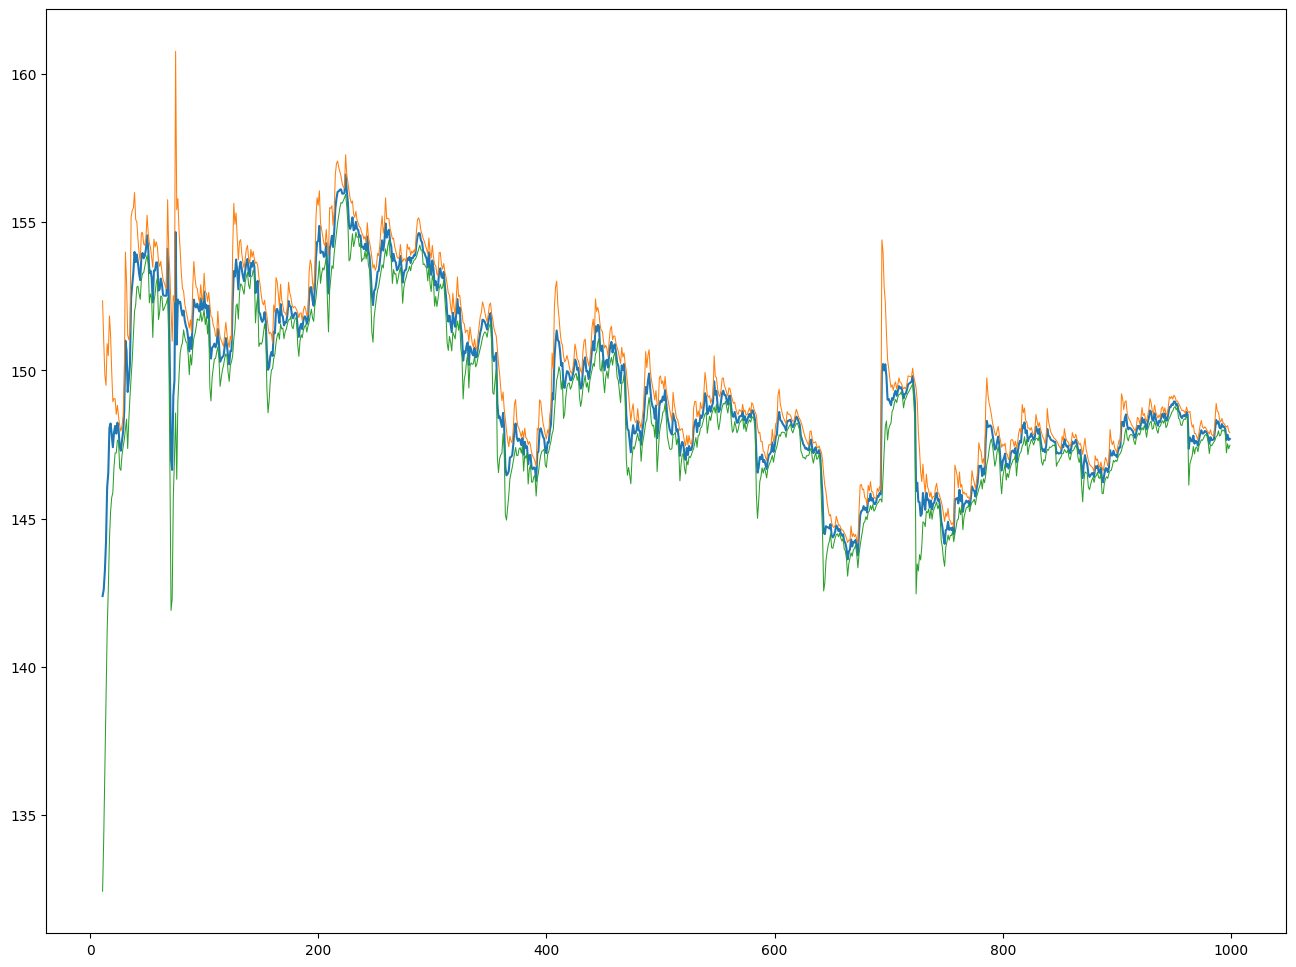

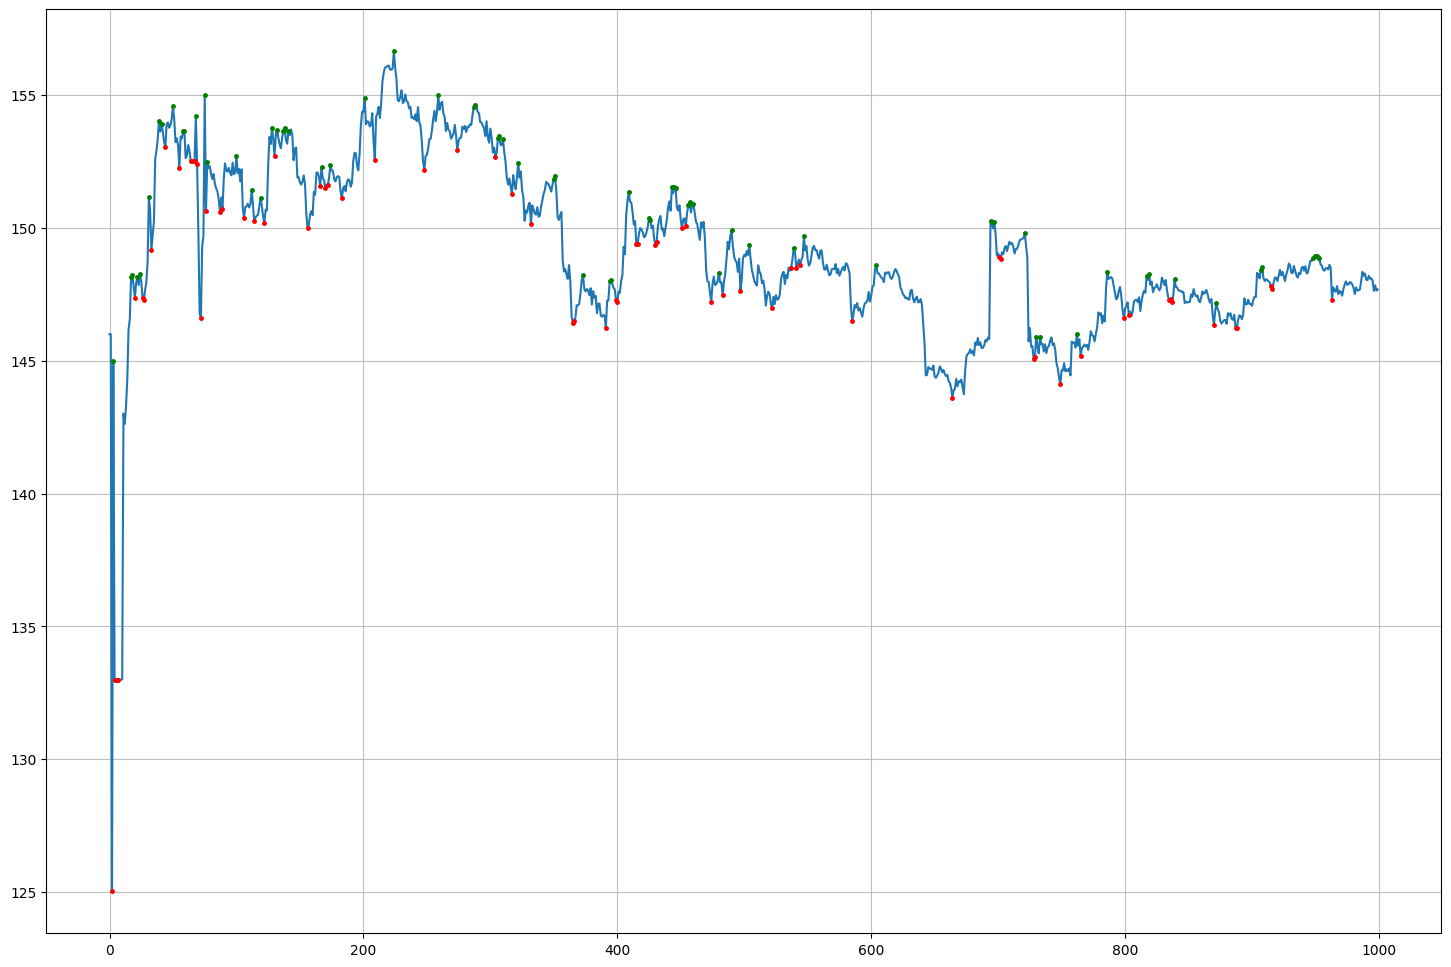

In [26]:
(f1, a1), (f2, a2) = sdb.plot_data()

In [19]:
peak_regions = sdb.labels[sdb.labels == 1].dropna().index.values
valley_regions = sdb.labels[sdb.labels == -1].dropna().index.values
neutral_regions = sdb.labels[sdb.labels == 0].dropna().index.values

In [39]:
peak_regions

array([   8,   30,   43,   55,   75,  106,  132,  142,  176,  177,  185,
        188,  199,  210,  230,  231,  232,  236,  257,  260,  261,  263,
        275,  276,  287,  309,  328,  330,  333,  339,  351,  354,  364,
        367,  380,  390,  392,  399,  410,  416,  425,  428,  430,  439,
        446,  451,  460,  483,  484,  501,  505,  509,  519,  530,  531,
        533,  534,  537,  544,  550,  572,  583,  601,  603,  611,  618,
        619,  633,  640,  648,  649,  657,  658,  664,  668,  682,  692,
        709,  711,  713,  723,  731,  742,  749,  755,  770,  784,  801,
        811,  824,  841,  869,  881,  884,  889,  904,  906,  915,  916,
        932,  933,  934,  944,  969,  981,  997,  998, 1010, 1030, 1050,
       1051, 1064, 1065, 1066, 1114, 1115, 1129, 1173, 1174, 1200, 1201,
       1258, 1350, 1381, 1382, 1383, 1411, 1412, 1443, 1444, 1445, 1460,
       1464, 1484, 1537, 1551, 1552, 1560, 1564, 1569, 1570, 1575, 1594,
       1602, 1653, 1663, 1665, 1693, 1694, 1695, 17

In [72]:
sdb.data = df
features =sdb.data

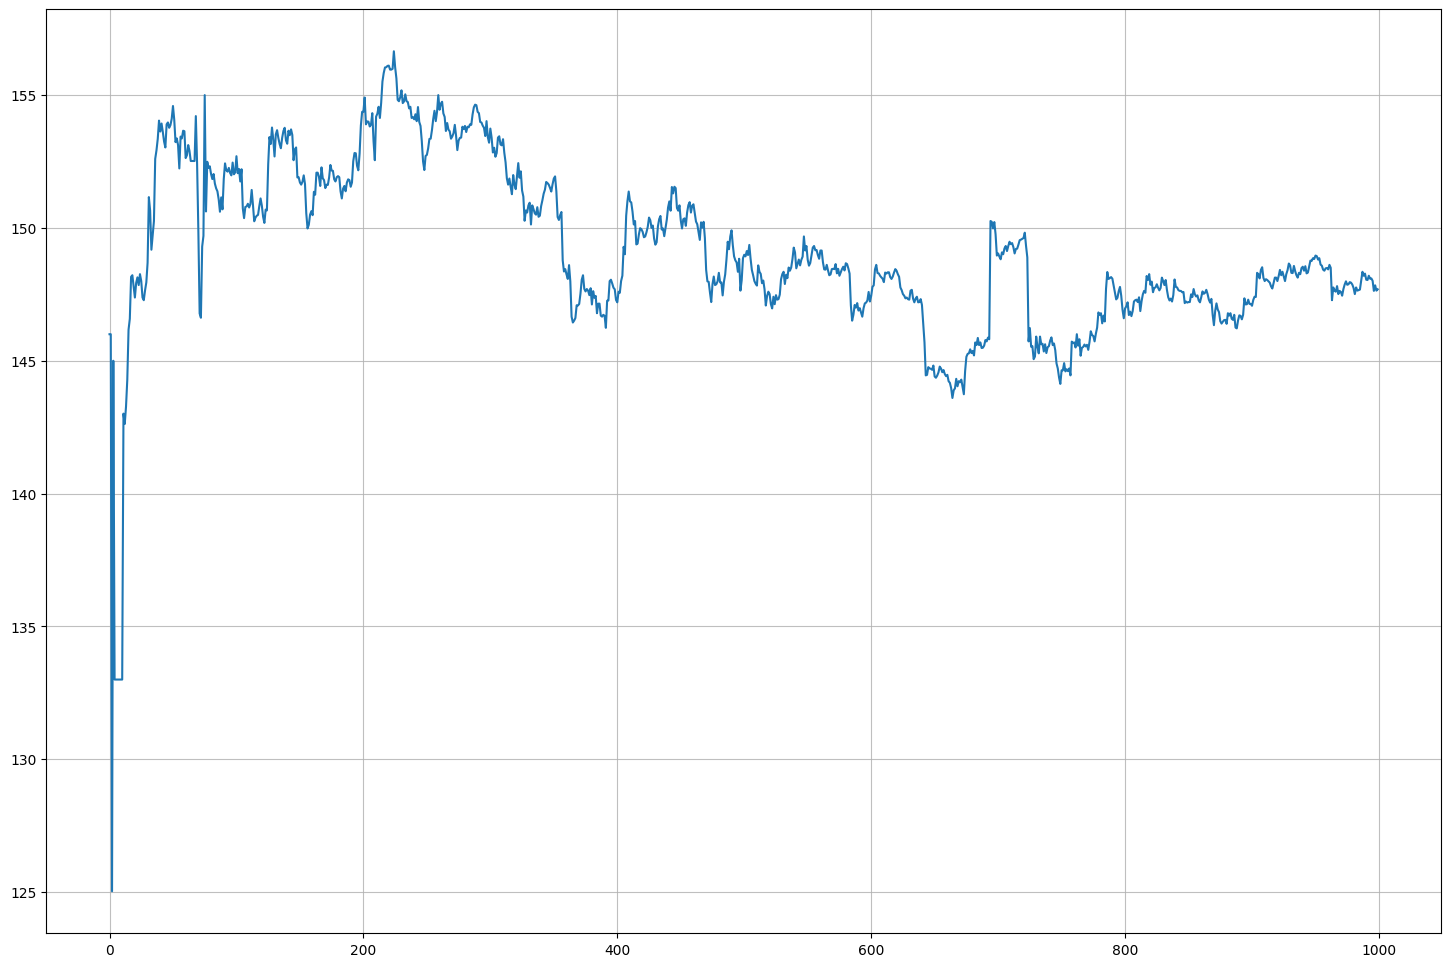

In [28]:
(fig, ax) = plt.subplots(figsize=(18,12))
ax.plot(sdb.data.close)
none = []
for i, l in enumerate(sdb.labels):
    if l == 1:
        peak_x = peak_regions
        peak_y = sdb.data.close.values[peak_regions]
        ax.plot(peak_x, peak_y, marker='o', linestyle="None", color='green', label="Peaks")
    elif l == -1:
        valley_x = valley_regions
        valley_y = sdb.data.close.values[valley_regions]
        ax.plot(valley_x, valley_y, marker='o', linestyle="None", color='red', label="Valleys")
    elif l == 0:
        none.append(i)
none_x = none
none_y = sdb.data.close.values[none]
# ax.plot(none_x, none_y, marker='o', linestyle="None", color='yellow', alpha=0.01, label="Valleys")        
# ax.plot(peak_x, peak_y, marker='o', linestyle="None", color='green', label="Peaks")
# ax.plot(valley_x, valley_y, marker='o', linestyle="None", color='red', label="Valleys")
ax.grid(which='both', alpha=0.8)
ax.grid(True, which="minor")

In [59]:
import torch
from torch.utils.data import Dataset
from torchvision import datasets
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt

class CustomDataset(Dataset):
    def __init__(self, data_path, transform=None, target_transform=None):

        # any additional label treatment
        self.labels = pd.read_csv(data_path + f"_labels{DUMP}")
        self.labels.drop(['Unnamed: 0'], axis=1, inplace=True)
        
        #feature engineering
        self.features = pd.read_csv(data_path + f"_features{DUMP}")
        self.features.drop(['Unnamed: 0'], axis=1, inplace=True)
        self.features.drop(['close_time'], axis=1, inplace=True)
        self.features.drop(['labels'], axis=1, inplace=True)
        
        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        return len(self.features)

    def __getitem__(self, idx):

        feature = self.features.iloc[idx, :]
        label = self.labels.iloc[idx]

        if self.transform:
            feature = self.transform(feature)
        if self.target_transform:
            label = self.target_transform(label)
        return feature, label

C:\Users\igor-\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [26]:
ds = CustomDataset(data_path)


In [27]:
from torch.utils.data import DataLoader

dataloader = DataLoader(ds, batch_size=64, shuffle=True)


In [28]:
ds.features

,open_time,open,high,low,close,volume,quote_asset_volume,trades,taker_buy_volume,taker_buy_quote_asset_volume
0,2019-11-27 07:45:00,146.00,146.00,146.00,146.00,0.010,1.460000e+00,1,0.000,0.000000e+00
1,2019-11-27 08:00:00,146.00,146.00,146.00,146.00,0.000,0.000000e+00,0,0.000,0.000000e+00
2,2019-11-27 08:15:00,125.03,125.03,125.03,125.03,0.010,1.250300e+00,1,0.000,0.000000e+00
3,2019-11-27 08:30:00,145.00,145.00,145.00,145.00,0.020,2.900000e+00,2,0.000,0.000000e+00
4,2019-11-27 08:45:00,145.01,145.01,133.00,133.00,0.050,6.770100e+00,2,0.010,1.450100e+00
...,...,...,...,...,...,...,...,...,...,...
10495,2020-03-17 14:00:00,113.09,114.91,112.51,113.82,35557.698,4.046765e+06,7112,18061.825,2.055813e+06
10496,2020-03-17 14:15:00,113.79,115.50,113.55,115.29,25336.127,2.901673e+06,5690,14325.847,1.641335e+06
10497,2020-03-17 14:30:00,115.28,115.68,114.04,115.40,34254.968,3.937871e+06,5930,17229.602,1.981916e+06
10498,2020-03-17 14:45:00,115.40,115.68,114.77,115.39,19647.917,2.263713e+06,3767,11837.663,1.364054e+06


In [29]:
ds.labels

,labels
0,0
1,0
2,-1
3,1
4,-1
...,...
10495,0
10496,0
10497,0
10498,0


In [30]:
dataloader.dataset.features

,open_time,open,high,low,close,volume,quote_asset_volume,trades,taker_buy_volume,taker_buy_quote_asset_volume
0,2019-11-27 07:45:00,146.00,146.00,146.00,146.00,0.010,1.460000e+00,1,0.000,0.000000e+00
1,2019-11-27 08:00:00,146.00,146.00,146.00,146.00,0.000,0.000000e+00,0,0.000,0.000000e+00
2,2019-11-27 08:15:00,125.03,125.03,125.03,125.03,0.010,1.250300e+00,1,0.000,0.000000e+00
3,2019-11-27 08:30:00,145.00,145.00,145.00,145.00,0.020,2.900000e+00,2,0.000,0.000000e+00
4,2019-11-27 08:45:00,145.01,145.01,133.00,133.00,0.050,6.770100e+00,2,0.010,1.450100e+00
...,...,...,...,...,...,...,...,...,...,...
10495,2020-03-17 14:00:00,113.09,114.91,112.51,113.82,35557.698,4.046765e+06,7112,18061.825,2.055813e+06
10496,2020-03-17 14:15:00,113.79,115.50,113.55,115.29,25336.127,2.901673e+06,5690,14325.847,1.641335e+06
10497,2020-03-17 14:30:00,115.28,115.68,114.04,115.40,34254.968,3.937871e+06,5930,17229.602,1.981916e+06
10498,2020-03-17 14:45:00,115.40,115.68,114.77,115.39,19647.917,2.263713e+06,3767,11837.663,1.364054e+06


In [8]:
import logging
from binance.um_futures import UMFutures
from binance.lib.utils import config_logging

config_logging(logging, logging.DEBUG)

um_futures_client = UMFutures()

logging.info(um_futures_client.trades("BTCUSDT", limit=500))

In [9]:
um_futures_client.

In [10]:
import logging
from binance.um_futures import UMFutures
from binance.lib.utils import config_logging

config_logging(logging, logging.DEBUG)

um_futures_client = UMFutures()

logging.info(
    um_futures_client.top_long_short_position_ratio("BTCUSDT", "1h", **{"limit": 30})
)

In [12]:
um_futures_client.top_long_short_position_ratio("BTCUSDT", "1h", **{"limit": 30})

[{'symbol': 'BTCUSDT',
  'longAccount': '0.5540',
  'longShortRatio': '1.2422',
  'shortAccount': '0.4460',
  'timestamp': 1665957600000},
 {'symbol': 'BTCUSDT',
  'longAccount': '0.5553',
  'longShortRatio': '1.2488',
  'shortAccount': '0.4447',
  'timestamp': 1665961200000},
 {'symbol': 'BTCUSDT',
  'longAccount': '0.5543',
  'longShortRatio': '1.2435',
  'shortAccount': '0.4457',
  'timestamp': 1665964800000},
 {'symbol': 'BTCUSDT',
  'longAccount': '0.5536',
  'longShortRatio': '1.2400',
  'shortAccount': '0.4464',
  'timestamp': 1665968400000},
 {'symbol': 'BTCUSDT',
  'longAccount': '0.5563',
  'longShortRatio': '1.2539',
  'shortAccount': '0.4437',
  'timestamp': 1665972000000},
 {'symbol': 'BTCUSDT',
  'longAccount': '0.5557',
  'longShortRatio': '1.2510',
  'shortAccount': '0.4443',
  'timestamp': 1665975600000},
 {'symbol': 'BTCUSDT',
  'longAccount': '0.5560',
  'longShortRatio': '1.2524',
  'shortAccount': '0.4440',
  'timestamp': 1665979200000},
 {'symbol': 'BTCUSDT',
  'l